In [1]:
import numpy as np
import random
import time
from sklearn import preprocessing
import matplotlib.pyplot as plt
import random
import pandas as pd

In [19]:
nums = [75, 3, 1, 4, 50, 6]
operadores = {1:"+", 2:"-", 3:"*"}

In [56]:
class DNA():
    def __init__(self, n_indiv, n_gener, target, crossover_rate, mutation_rate, n_selection, selection_type, crossover_type):
        self.n_indiv = n_indiv
        self.n_gener = n_gener
        self.target = target
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate
        self.n_selection = n_selection
        self.selection_type = selection_type
        self.crossover_type = crossover_type
        self.best_fitness = [10000, [], 0] # fitness_value, number of iters without update
        self.lista_best_fitness = []

    def create_individuo(self, min=1, max=4):
        individuo = list(np.random.randint(min,max,len(nums)-1))
        return individuo
    
    def create_population(self):
        population = [self.create_individuo() for i in range(self.n_indiv)]
        return population
    
    def fitness(self, individuo):
        value = nums[0]
        for i, elem in enumerate(individuo):
            if elem == 1:
                value += nums[i+1]
            elif elem == 2:
                value -= nums[i+1]
            elif elem == 3:
                value *= nums[i+1]
        if value < 0:
            value = abs(value - self.target)
        else:
            value = abs(self.target - value)
        return value
    
    def evaluate_generation(self, population):
        scores = [self.fitness(individuo) for individuo in population]
        if min(scores) < self.best_fitness[0]:
            self.best_fitness[0] = min(scores)
            self.best_fitness[1] = population[scores.index(min(scores))]
            self.best_fitness[2] = 0
        else:
            self.best_fitness[2] += 1
        return 
        
    def k_mejores(self, population):
        scores = [(individuo, self.fitness(individuo)) for individuo in population]
        individuals_sorted = [elem[0] for elem in sorted(scores, key=lambda tup: tup[1])]
        return individuals_sorted[:self.n_selection]
        
    def tournament(self, population):
        new_population = []
        scores = [[individuo, self.fitness(individuo), 0] for individuo in population]
        while len(new_population) < self.n_indiv:
            P1 = np.random.randint(0, len(scores))
            P2 = np.random.randint(0, len(scores))
            while P1 == P2:
                P2 = np.random.randint(0, len(scores))
            parent1 = scores[P1]
            parent2 = scores[P2]
            scores[P1][2] += 1
            scores[P2][2] += 1
            winner = min([parent1, parent2], key = lambda t: t[1])
            new_population.append(winner[0])
            if scores[P1] == 2:
                scores.pop(P1)
            if scores[P2] == 2:
                scores.pop(P2)
        return new_population
    
    def selection(self, population):
        if self.selection_type == "k_mejores":
            population = self.k_mejores(population)
        else:
            population = self.tournament(population)
        return population
    
    def crossover_one_point(self,parents,new_population):
        index = np.random.choice(range(len(nums)-1))
        new_population.append([*parents[0][:index],*parents[1][index:]])
        new_population.append([*parents[1][:index],*parents[0][index:]])
        return new_population
    
    def crossover_two_points(self,parents,new_population):
        index1 = np.random.choice(range(len(nums)-1))
        index2 = np.random.choice(range(len(nums)-1))
        while index1 == index2:
            index2 = np.random.choice(range(len(nums)-1))
        sorted_index = sorted([index1,index2])
    
        new_population.append([*parents[0][:sorted_index[0]],*parents[1][sorted_index[0]:sorted_index[1]],*parents[0][sorted_index[1]:]])
        new_population.append([*parents[1][:sorted_index[0]],*parents[0][sorted_index[0]:sorted_index[1]],*parents[1][sorted_index[1]:]])
        return new_population
        
    def crossover_uniform(self,parents,new_population):
        mask = random.choices([0,1], k=len(nums)-1)
        children1 = []
        children2 = []
        for index, value in enumerate(mask):
            if value == 1:
                children1.append(parents[0][index])
                children2.append(parents[1][index])
            else:
                children1.append(parents[1][index])
                children2.append(parents[0][index])
        new_population.append(children1)
        new_population.append(children2)
        return new_population
        
    def reproduction(self, candidates):
        new_population = []
        while len(new_population) < self.n_indiv:
            parents = random.sample(candidates, 2)
            if random.random() <= self.crossover_rate:
                if self.crossover_type == "one-point":
                    new_population = self.crossover_one_point(parents, new_population)
                elif self.crossover_type == "two-points":
                    new_population = self.crossover_two_points(parents, new_population)
                else:
                    new_population = self.crossover_uniform(parents, new_population)
            else:
                new_population.append(parents[0])
                new_population.append(parents[1])
                candidates.remove(parents[0])
                candidates.remove(parents[1])
        return new_population
    
    def mutation(self, population):
        for i, indv in enumerate(population):
            for j in range(len(indv)):
                if random.random() <= self.mutation_rate:
                #point = np.random.randint(0, len(population[i]))
                    new_alelo = np.random.randint(1, 4)
                    while new_alelo == indv[j]:
                        new_alelo = np.random.randint(1, 4)
                    population[i][j] = new_alelo
                
        return population
    
    def run(self):
        population = self.create_population()
        #print(population)
        for i in range(self.n_gener):
            # print("______________________")
            # print("GENERATION: ", i)
            # print("BEST_FITNESS: ", self.best_fitness[0][0])
            self.evaluate_generation(population)
            #self.lista_best_fitness.append(self.best_fitness[0][0])
            if self.best_fitness[0] != 0 and self.best_fitness[2] < 15:
                selected = self.selection(population)
                population = self.reproduction(selected)
                population = self.mutation(population)
            else:
                break
        return self.best_fitness[0], self.best_fitness[1]

### EJECUCIÓN PARA DETERMINAR VALORES CROSSOVER Y MUTATION RATE

In [4]:
    
M_error = np.empty((0,11), np.float64)
M_time = np.empty((0,11), np.float64)

number_iterations = 50

crossover_types = ["one-point","two-points","uniform"]

for crossover_rate in np.arange(0.0, 1.1, 0.1):
#for crossover_rate in [0.1]:    
    print("______________________")
    print("CROSSOVER_RATE: ", crossover_rate)
    print("______________________")
    l1 = []
    l2 = []
    for mutation_rate in np.arange(0.0, 1.1, 0.1):
        print("***********************")
        print("MUTATION_RATE: ", mutation_rate)
        print("***********************")
        params = {"n_indiv":10, "n_gener":100, "target":852, "crossover_rate":crossover_rate,
                    "mutation_rate":mutation_rate, "n_selection":20, "selection_type":"tournament",
                    "crossover_type":crossover_types[2]}
        contador_error = 0
        contador_time = 0
        for i in range(number_iterations):
            model = DNA(params["n_indiv"], params["n_gener"], params["target"], params["crossover_rate"], params["mutation_rate"], params["n_selection"]
                , params["selection_type"], params["crossover_type"])
            start = time.time()
            error = model.run()
            end = time.time()
            contador_error += error
            contador_time += (end-start)    
        l1.append(contador_error/number_iterations)
        l2.append(contador_time/number_iterations)
        
    
    M_error = np.append(M_error, np.array([l1]), axis=0)
    M_time = np.append(M_time, np.array([l2]), axis=0)
print(M_error)
print(M_time)

______________________
CROSSOVER_RATE:  0.0
______________________
***********************
MUTATION_RATE:  0.0
***********************
***********************
MUTATION_RATE:  0.1
***********************
***********************
MUTATION_RATE:  0.2
***********************
***********************
MUTATION_RATE:  0.30000000000000004
***********************
***********************
MUTATION_RATE:  0.4
***********************
***********************
MUTATION_RATE:  0.5
***********************
***********************
MUTATION_RATE:  0.6000000000000001
***********************
***********************
MUTATION_RATE:  0.7000000000000001
***********************
***********************
MUTATION_RATE:  0.8
***********************
***********************
MUTATION_RATE:  0.9
***********************
***********************
MUTATION_RATE:  1.0
***********************
______________________
CROSSOVER_RATE:  0.1
______________________
***********************
MUTATION_RATE:  0.0
***********************
****

### EJECUCIÓN PARA OBTENER VALORES DE POBLACIÓN EN BASE A VALORES OBTENIDOS DE MUTATION Y CROSSOVER RATE


In [5]:
M_error = np.empty((0,11), np.float64)
M_time = np.empty((0,11), np.float64)

number_iterations = 50
M_error = []
M_time = []
params = {"n_indiv":10, "n_gener":100, "target":852, "crossover_rate":0.7,
                    "mutation_rate":0.3, "n_selection":20, "selection_type":"tournament",
                    "crossover_type":"uniform"}
for n_indv in [10,20,30,40,50,60,70,80,90,100]:
    print("______________________")
    print("NUMBER OF INDIVIDUALS: ", n_indv)
    print("______________________")
    
    contador_error = 0
    contador_time = 0
    for i in range(number_iterations):
        model = DNA(n_indv, params["n_gener"], params["target"], params["crossover_rate"], params["mutation_rate"], params["n_selection"]
            , params["selection_type"], params["crossover_type"])
        start = time.time()
        error = model.run()
        end = time.time()
        contador_error += error
        contador_time += (end-start)    
    M_error.append(contador_error/number_iterations)
    M_time.append(contador_time/number_iterations)
    
print(M_error)
print(M_time)

______________________
NUMBER OF INDIVIDUALS:  10
______________________
______________________
NUMBER OF INDIVIDUALS:  20
______________________
______________________
NUMBER OF INDIVIDUALS:  30
______________________
______________________
NUMBER OF INDIVIDUALS:  40
______________________
______________________
NUMBER OF INDIVIDUALS:  50
______________________
______________________
NUMBER OF INDIVIDUALS:  60
______________________
______________________
NUMBER OF INDIVIDUALS:  70
______________________
______________________
NUMBER OF INDIVIDUALS:  80
______________________
______________________
NUMBER OF INDIVIDUALS:  90
______________________
______________________
NUMBER OF INDIVIDUALS:  100
______________________
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0067000150680541996, 0.009499969482421875, 0.01326003074645996, 0.01509995460510254, 0.0169000244140625, 0.019859976768493652, 0.022500004768371582, 0.02413998603820801, 0.02823997974395752, 0.030100021362304687]


In [6]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [7]:
min_max_scaler = preprocessing.MinMaxScaler()
print(M_error)
print(M_time)

error_norm = NormalizeData(M_error)
time_norm = NormalizeData(M_time)


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0067000150680541996, 0.009499969482421875, 0.01326003074645996, 0.01509995460510254, 0.0169000244140625, 0.019859976768493652, 0.022500004768371582, 0.02413998603820801, 0.02823997974395752, 0.030100021362304687]


C:\Users\norao\AppData\Local\Temp\ipykernel_12400\2012354504.py:2: RuntimeWarning: invalid value encountered in true_divide
  return (data - np.min(data)) / (np.max(data) - np.min(data))


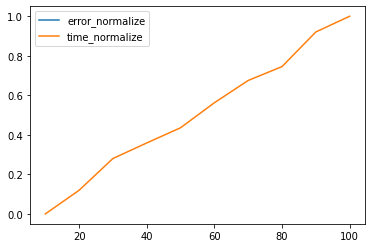

In [8]:
X = [10,20,30,40,50,60,70,80,90,100]
plt.plot(X,error_norm, label= "error_normalize")
plt.plot(X,time_norm, label= "time_normalize")
plt.legend()


In [133]:
M_funcion = np.empty((0,11), np.float64)
for i, row in enumerate(error_norm):
    l = []
    for j, column_value in enumerate(row):
        funcion = 0.3 * time_norm[i][j] + 0.7 * column_value
        l.append(funcion)
    M_funcion = np.append(M_funcion, np.array([l]), axis=0)
df = pd.DataFrame(M_funcion)
df.columns = [str(column).ljust(4, '0') for column in df.columns]
df



,0000,1000,2000,3000,4000,5000,6000,7000,8000,9000,1000
0,0.700707,0.121273,0.109742,0.200294,0.170763,0.228279,0.254617,0.248173,0.264991,0.306576,0.318333
1,0.822374,0.067127,0.089388,0.082151,0.112435,0.150968,0.135484,0.188593,0.191530,0.191532,0.226560
2,0.530058,0.034355,0.047120,0.027799,0.083731,0.082715,0.117404,0.149156,0.146226,0.144070,0.189050
3,0.580586,0.014126,0.039956,0.036950,0.054013,0.069719,0.091188,0.101245,0.130173,0.151413,0.149945
4,0.676074,0.032319,0.021583,0.006781,0.042826,0.051187,0.055593,0.101246,0.092769,0.113787,0.164974
5,0.674637,0.033231,0.020905,0.013560,0.060001,0.038645,0.067799,0.095369,0.080566,0.137402,0.127573
6,0.446608,0.003278,0.012431,0.008137,0.026441,0.064634,0.064746,0.084634,0.104295,0.116498,0.133221
7,0.411272,0.032106,0.007121,0.000000,0.033560,0.049380,0.074465,0.052542,0.109153,0.085424,0.141809
8,0.400988,0.035386,0.005086,0.027120,0.031075,0.049040,0.050734,0.087006,0.085085,0.113900,0.119097
9,0.362375,0.011197,0.000340,0.019324,0.029831,0.043052,0.050848,0.073899,0.079210,0.117403,0.107233


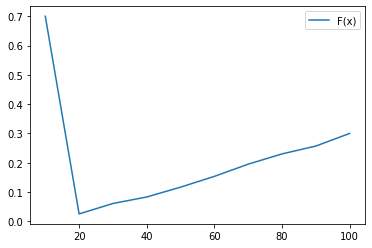

In [9]:
l = []
for i, elem in enumerate(error_norm):
    funcion = 0.3 * time_norm[i] + 0.7 * elem
    l.append(funcion)
index_min = np.where(l==np.min(l))
X = [10,20,30,40,50,60,70,80,90,100]

plt.plot(X,l, label= "F(x)")
plt.legend()

In [ ]:
print(np.where(M_funcion == np.min(M_funcion)))

(array([8], dtype=int64), array([3], dtype=int64))


### EJECUCIÓN FINAL DEL PROBLEMA

In [60]:
error_optimo = 10000
solucion_optima = []
number_iterations = 100
combinations = [("one-point",0.4,0.1),("two-points",0.3,0.1),("uniform",0.7,0.3)]
params = {"n_indiv":10, "n_gener":100, "target":852, "crossover_rate":combinations[1][1],
                    "mutation_rate":combinations[2][2], "n_selection":20, "selection_type":"tournament",
                    "crossover_type":combinations[2][0]}
for i in range(number_iterations):
    model = DNA(params["n_indiv"], params["n_gener"], params["target"], params["crossover_rate"], params["mutation_rate"], params["n_selection"]
        , params["selection_type"], params["crossover_type"])
    error, indv = model.run()
    if error < error_optimo:
        error_optimo = error
        solucion = [operadores[elem] for elem in indv]
        solucion_optima = solucion
print(error_optimo)
print(solucion_optima)

0
['*', '-', '*', '-', '+']
